In [ ]:
pip install tweepy

In [46]:
import tweepy
import csv
import io
import pandas as pd
import numpy as np
import string
import re
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
plt.style.use('fivethirtyeight')
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

In [12]:
#auth key and token
consumer_key = "H7slMvApO8OvjCaWjkIVToP6s"
consumer_secret = "tIpwnLKUzuaTcOIEW7T5dH2POqUaCSBpPEa1DhfuCoMCcDdnc0"
access_key = "1184107579883999233-nLXcyrr9t48yqSQdtKHq38quvEPd94"
access_secret = "sfeo5utwasImYLg6yDzjw8TZX0nq1KP4jR4bXbrKXSgI5"
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.favorite_count, tweet.text] for tweet in alltweets]
    
    #write the csv  
    with io.open(f'{screen_name}_tweets.csv', 'w',newline='',encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["tweet_id","favorite_count","tweets"])
        writer.writerows(outtweets)
    
    pass


if __name__ == '__main__':
	#pass in the username of the account you want to download
	get_all_tweets("KnightFrankKE")


getting tweets before 1311210246195511295
...400 tweets downloaded so far
getting tweets before 1245696690348269567
...600 tweets downloaded so far
getting tweets before 1128182727390396415
...800 tweets downloaded so far
getting tweets before 1103597099009130495
...1000 tweets downloaded so far
getting tweets before 1097777814089203717
...1199 tweets downloaded so far
getting tweets before 1027527896028655616
...1398 tweets downloaded so far
getting tweets before 986578552161296383
...1597 tweets downloaded so far
getting tweets before 971623964241027073
...1792 tweets downloaded so far
getting tweets before 927890634408714239
...1992 tweets downloaded so far
getting tweets before 904932195483209727
...2192 tweets downloaded so far
getting tweets before 862326932637196287
...2392 tweets downloaded so far
getting tweets before 839521842700382210
...2592 tweets downloaded so far
getting tweets before 806374267583655935
...2789 tweets downloaded so far
getting tweets before 7861342786859

In [15]:
# read file
file = pd.read_csv('KnightFrankKE_tweets.csv')
file.head()

,tweet_id,favorite_count,tweets
0,1377929107472846848,1,"Do you see the ""15-minute"" city becoming a rea..."
1,1377610208546021383,0,This contemporary 3 bedroom #apartment in #Kil...
2,1377592653794119685,1,Has the pandemic fast-tracked #realestate inno...
3,1377192072164352000,0,"To accompany this year's #WealthReport2021, we..."
4,1376824530665111555,0,This newly built 4 bedroom home off Ngecha Roa...


In [16]:
#dataframe
tweets_df = file[["tweet_id", "tweets"]]
tweets_df.head()

,tweet_id,tweets
0,1377929107472846848,"Do you see the ""15-minute"" city becoming a rea..."
1,1377610208546021383,This contemporary 3 bedroom #apartment in #Kil...
2,1377592653794119685,Has the pandemic fast-tracked #realestate inno...
3,1377192072164352000,"To accompany this year's #WealthReport2021, we..."
4,1376824530665111555,This newly built 4 bedroom home off Ngecha Roa...


In [17]:
#start process_tweet
def processTweet(tweet):
    # process the tweets

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    #remove punctuations
    tweet = re.sub(r'[^\w\s]','',tweet)
    return tweet
#end
tweets_df["tweet_punctuated"] = tweets_df["tweets"].apply(lambda x: processTweet(x))
print(tweets_df["tweet_punctuated"])

0       do you see the 15minute city becoming a realit...
1       this contemporary 3 bedroom apartment in kilel...
2       has the pandemic fasttracked realestate innova...
3       to accompany this years wealthreport2021 we ha...
4       this newly built 4 bedroom home off ngecha roa...
                              ...                        
3216     fielded 2 teams during the wwr2016 and emerge...
3217       rt team knight frank ready for the fun wwr2016
3218    rt congratulations team knight frank for winni...
3219    rt congratulations knight frank team 1 and 2 f...
3220    rt if you didnt get a chance to read tuesdays ...
Name: tweet_punctuated, Length: 3221, dtype: object


In [18]:
#tokenize
from nltk.tokenize import word_tokenize
tweet_punctuated = tweets_df["tweet_punctuated"] 
word_tokens = []
for each in tweet_punctuated:
  word_tokens.append(word_tokenize(each))
words_tokens =[]
for each in word_tokens:
  words_tokens.append(each)
tweets_df["tweet_tokenized"] = words_tokens
print(tweets_df["tweet_tokenized"])

0       [do, you, see, the, 15minute, city, becoming, ...
1       [this, contemporary, 3, bedroom, apartment, in...
2       [has, the, pandemic, fasttracked, realestate, ...
3       [to, accompany, this, years, wealthreport2021,...
4       [this, newly, built, 4, bedroom, home, off, ng...
                              ...                        
3216    [fielded, 2, teams, during, the, wwr2016, and,...
3217    [rt, team, knight, frank, ready, for, the, fun...
3218    [rt, congratulations, team, knight, frank, for...
3219    [rt, congratulations, knight, frank, team, 1, ...
3220    [rt, if, you, didnt, get, a, chance, to, read,...
Name: tweet_tokenized, Length: 3221, dtype: object


In [19]:
#remove stopwords
from nltk.corpus import stopwords
stopword = nltk.corpus.stopwords.words('english')
final_token = []
for c in words_tokens:
  for d in c:
    if d not in stopword:
      final_token.append(d)
print(final_token[:100])

['see', '15minute', 'city', 'becoming', 'reality', 'africa', 'tilda', 'mwai', 'knightfrank', 'researcher', 'africa', 'says', 'contemporary', '3', 'bedroom', 'apartment', 'kileleshwa', 'available', 'rent', '220000', 'per', 'month', 'pandemic', 'fasttracked', 'realestate', 'innovation', 'tilda', 'mwai', 'knightfrank', 'researcher', 'africa', 'notes', '42', 'accompany', 'years', 'wealthreport2021', 'published', 'african', 'supplement', 'looks', 'africa', 'per', 'newly', 'built', '4', 'bedroom', 'home', 'ngecha', 'road', 'kitisuru', 'available', 'forsale', 'kes', '50m', 'set', 'within', 'gated', 'rent', '5', 'bedroom', 'home', 'within', 'gated', 'compound', 'runda', '400000', 'per', 'month', 'features', 'include', 'living', 'ro', 'resilient', 'sector', 'property', 'market', 'kenya', 'md', 'ben', 'woodhams', 'gets', 'unique', 'f', '3', 'bedroom', 'house', 'approx', '2', 'acres', 'kilifi', 'available', 'sale', 'kes', '40m', 'en', 'suite', 'bedrooms', 'rental', 'prices', 'prime']


In [20]:
#stemming
string.punctuation
from nltk.stem.porter import *
stemmer = PorterStemmer()
tweets_df["tweet_tokenized"] = tweets_df["tweet_tokenized"].apply(lambda x: [stemmer.stem(w) for w in x])
tweets_df.head()

,tweet_id,tweets,tweet_punctuated,tweet_tokenized
0,1377929107472846848,"Do you see the ""15-minute"" city becoming a rea...",do you see the 15minute city becoming a realit...,"[do, you, see, the, 15minut, citi, becom, a, r..."
1,1377610208546021383,This contemporary 3 bedroom #apartment in #Kil...,this contemporary 3 bedroom apartment in kilel...,"[thi, contemporari, 3, bedroom, apart, in, kil..."
2,1377592653794119685,Has the pandemic fast-tracked #realestate inno...,has the pandemic fasttracked realestate innova...,"[ha, the, pandem, fasttrack, realest, innov, t..."
3,1377192072164352000,"To accompany this year's #WealthReport2021, we...",to accompany this years wealthreport2021 we ha...,"[to, accompani, thi, year, wealthreport2021, w..."
4,1376824530665111555,This newly built 4 bedroom home off Ngecha Roa...,this newly built 4 bedroom home off ngecha roa...,"[thi, newli, built, 4, bedroom, home, off, nge..."


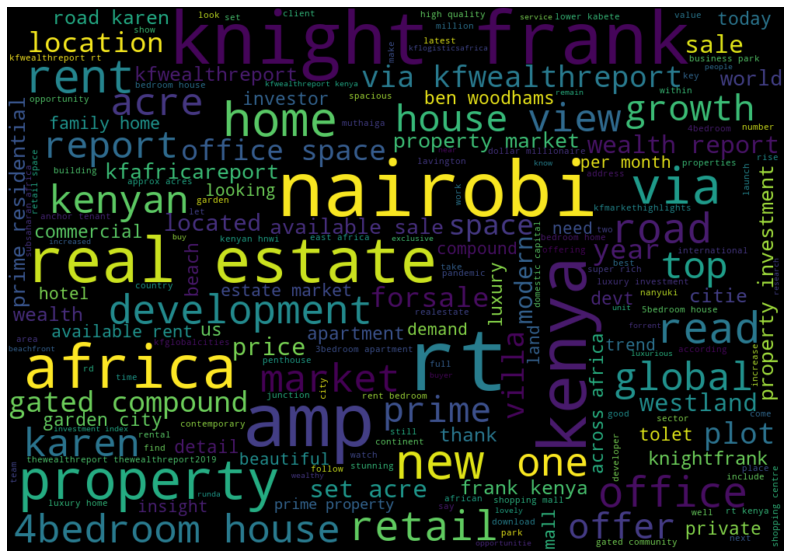

In [21]:
#wordcloud visualization
all_words = ' '.join([text for text in final_token])
from wordcloud import WordCloud
wordcloud = WordCloud(width=1000, height=700, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [22]:
#common words
freq = nltk.FreqDist(final_token)
freq.most_common(10)

[('rt', 517),
 ('property', 372),
 ('via', 324),
 ('house', 317),
 ('nairobi', 311),
 ('kenya', 305),
 ('amp', 300),
 ('knight', 281),
 ('road', 277),
 ('africa', 266)]

In [23]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [31]:
def sentiment_score_compound(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['compound']

def sentiment_score_pos(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['pos']

def sentiment_score_neg(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['neg']

def sentiment_score_neu(sentence):
    score = analyzer.polarity_scores(sentence)
    return score['neu']
tweets_df["sentiment_compound"] = tweets_df["tweet_punctuated"].apply(lambda x: sentiment_score_compound(x))
tweets_df["sentiment_positive"] = tweets_df["tweet_punctuated"].apply(lambda x: sentiment_score_pos(x))
tweets_df["sentiment_negative"] = tweets_df["tweet_punctuated"].apply(lambda x: sentiment_score_neg(x))
tweets_df.head()

,tweet_id,tweets,tweet_punctuated,tweet_tokenized,sentiment_compound,sentiment_positive,sentiment_negative,label
0,1377929107472846848,"Do you see the ""15-minute"" city becoming a rea...",do you see the 15minute city becoming a realit...,"[do, you, see, the, 15minut, citi, becom, a, r...",0.0000,0.000,0.0,1
1,1377610208546021383,This contemporary 3 bedroom #apartment in #Kil...,this contemporary 3 bedroom apartment in kilel...,"[thi, contemporari, 3, bedroom, apart, in, kil...",0.0000,0.000,0.0,1
2,1377592653794119685,Has the pandemic fast-tracked #realestate inno...,has the pandemic fasttracked realestate innova...,"[ha, the, pandem, fasttrack, realest, innov, t...",0.3818,0.157,0.0,1
3,1377192072164352000,"To accompany this year's #WealthReport2021, we...",to accompany this years wealthreport2021 we ha...,"[to, accompani, thi, year, wealthreport2021, w...",0.0000,0.000,0.0,1
4,1376824530665111555,This newly built 4 bedroom home off Ngecha Roa...,this newly built 4 bedroom home off ngecha roa...,"[thi, newli, built, 4, bedroom, home, off, nge...",0.0000,0.000,0.0,1


In [32]:
#vectorize
wordlist = nltk.FreqDist(all_words)
word_features = wordlist.keys()

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
tweets_list = []
for tweet in tweets_df["tweet_punctuated"]:
  
  tweets_list.append(tweet)
len(tweets_list)
tweets_df.shape

X = tweets_df["tweet_punctuated"]

vec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2))

In [26]:
#tweet labelling
def label_value(val):
  if val < 0:
    return 0
  else:
    return 1
tweets_df["label"] = tweets_df["sentiment_compound"].apply(lambda x: label_value(x))
tweets_df.head()

,tweet_id,tweets,tweet_punctuated,tweet_tokenized,sentiment_compound,sentiment_positive,sentiment_negative,label
0,1377929107472846848,"Do you see the ""15-minute"" city becoming a rea...",do you see the 15minute city becoming a realit...,"[do, you, see, the, 15minut, citi, becom, a, r...",0.0000,0.000,0.0,1
1,1377610208546021383,This contemporary 3 bedroom #apartment in #Kil...,this contemporary 3 bedroom apartment in kilel...,"[thi, contemporari, 3, bedroom, apart, in, kil...",0.0000,0.000,0.0,1
2,1377592653794119685,Has the pandemic fast-tracked #realestate inno...,has the pandemic fasttracked realestate innova...,"[ha, the, pandem, fasttrack, realest, innov, t...",0.3818,0.157,0.0,1
3,1377192072164352000,"To accompany this year's #WealthReport2021, we...",to accompany this years wealthreport2021 we ha...,"[to, accompani, thi, year, wealthreport2021, w...",0.0000,0.000,0.0,1
4,1376824530665111555,This newly built 4 bedroom home off Ngecha Roa...,this newly built 4 bedroom home off ngecha roa...,"[thi, newli, built, 4, bedroom, home, off, nge...",0.0000,0.000,0.0,1


In [33]:
#train test
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(tweets_list)
X = cv.transform(tweets_list)
y = tweets_df["label"].values

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X, y, train_size = 0.2, random_state = 0)

In [34]:
#Naive Bayes model Acc: gives 95% acc
from sklearn.naive_bayes import MultinomialNB
NB_model  = MultinomialNB()
NB_model .fit(X_train, y_train)
pred = NB_model .predict(X_val)
print(accuracy_score(y_val, pred))

0.9487776484284052


In [35]:
#Logistics Regression model Acc: gives 95%
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
pred = LR_model.predict(X_val)
print(accuracy_score(y_val, pred))

0.9495537446643384


In [36]:
#Support Vector Machine Acc: gives 95%
from sklearn.svm import LinearSVC
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit(tweets_list)
X = ngram_vectorizer.transform(tweets_list)
y = tweets_df["label"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.2, random_state = 0)
SVM_model = LinearSVC()
SVM_model.fit(X_train, y_train)

pred = SVM_model.predict(X_val)
print(accuracy_score(y_val, pred))

0.9507178890182383


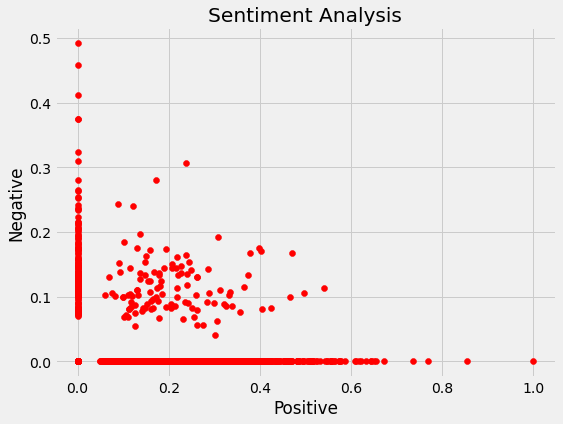

In [58]:
import matplotlib.pyplot as PLOT
# Plotting 
PLOT.figure(figsize=(8,6)) 
for i in range(0, tweets_df.shape[0]):
  PLOT.scatter(tweets_df["sentiment_positive"][i], tweets_df["sentiment_negative"][i], color='red') 
# plt.scatter(x,y,color)   
PLOT.title('Sentiment Analysis') 
PLOT.xlabel('Positive') 
PLOT.ylabel('Negative') 
PLOT.show()